### Imports

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error    

### Loading and Cleaning dataset

In [12]:
df = pd.read_csv("selected.csv", index_col = False)
df.drop(["Unnamed: 0"], inplace = True, axis = 1)
df = df.replace(' NA', np.nan)
df = df.replace('NA', np.nan)
df['NPI'] = df['NPI'].astype('float')
df['NPI'].replace(np.nan, df['NPI'].mean(), inplace = True)
df.head()

,219340_s_at,217771_at,202418_at,206295_at,201091_s_at,204015_s_at,200726_at,200965_s_at,210314_x_at,221882_s_at,...,t.dmfs,e.dmfs,t.tdm,e.tdm,risksg,NPI,risknpi,AOL_os_10y,risk_AOL,veridex_risk
0,7.014110,9.938705,11.053083,5.326001,10.964107,6.244280,10.926361,8.962608,10.523859,10.926365,...,723,1,723,1,2,4.60,2,62.7,1,Poor
1,7.326724,6.374728,10.596457,8.290123,11.594716,6.542130,12.242090,9.531718,10.342614,9.555092,...,6591,0,6591,0,2,4.60,2,69.0,1,Poor
2,6.974651,9.226757,10.834848,5.731169,9.166088,6.586000,11.661716,10.238680,10.144875,9.308048,...,524,1,524,1,2,4.50,2,66.2,1,Poor
3,7.703683,8.169183,11.627066,8.538247,9.086937,8.477335,12.174021,9.819279,10.888251,10.208241,...,6255,1,6255,0,2,4.36,2,84.9,1,Poor
4,6.581141,7.496745,11.500773,5.979282,8.887616,7.398170,11.484011,11.489233,9.702690,10.931843,...,3822,1,3822,1,2,3.60,2,80.2,1,Poor


### Choosing columns for training

In [13]:
removals = ['t.rfs', 'e.rfs', 't.os', 'e.os', 't.dmfs','e.dmfs', 't.tdm', 'e.tdm', "samplename", "id","filename","hospital", 'Surgery_type', 'Histtype', 'Angioinv', 'Lymp_infil', 'node', 'grade', 'er', 'risksg', 'risknpi', 'risk_AOL', 'veridex_risk']
rest = [i for i in df.columns if i not in removals]

In [14]:
X = df[rest]
y = df["t.tdm"]

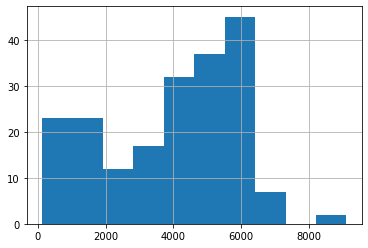

In [15]:
y.hist()

### Defining Indicator Functions

In [6]:
steps = 100
indicators = np.arange(0,10000,steps)

for indicator in indicators:
    df['indi_'+str(indicator)]= y < indicator
    

### Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, df[['indi_'+str(indicator) for indicator in indicators]], test_size=0.33, random_state=42)
columns = y_train.columns

In [8]:
for i,column in enumerate(columns):
    if( y_train[column].nunique()==1):
        y_test["prob_" + column] = 0
        y_test["survival_simple_" + column] = 1
        y_test["survival_log_" + column] = 0
        y_test["hazard_" + column] = 0
        continue
        
    clf = LogisticRegression(random_state=0,solver='liblinear').fit(X_train, y_train[column])
    y_test["prob_" + column] = clf.predict_proba(X_test)[:,1]
    
    if(i>1):
        y_test["prob_" + column] =  np.maximum(y_test["prob_" + columns[i-1]],y_test["prob_" + column])
        y_test["survival_simple_" + column] = 1 - y_test["prob_" + column]
        
        y_test["survival_log_" + column] = np.log(y_test["survival_simple_" + column])
        y_test["hazard_" + column] = ( - y_test["survival_log_" + columns[i]] + y_test["survival_log_" + columns[i-1]])/steps


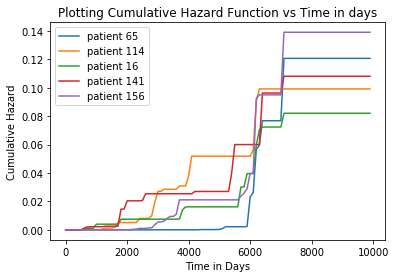

In [9]:
plt.figure()
for i in range(5):
    plt.plot(indicators, y_test.iloc[i,:][y_test.columns[y_test.columns.str.startswith("hazard_")]].cumsum(), label=f"patient {X_test.iloc[i].name}")
    
plt.xlabel('Time in Days')
plt.ylabel('Cumulative Hazard')
plt.xlabel('Time in Days')
plt.title("Plotting Cumulative Hazard Function vs Time in days")
plt.legend()

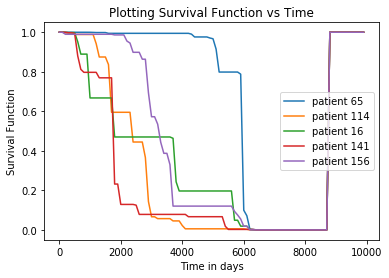

In [10]:
plt.figure()
for i in range(5):
    plt.plot(indicators, y_test.iloc[i,:][y_test.columns[y_test.columns.str.startswith("survival_simple_")]], label=f"patient {X_test.iloc[i].name}")
    
plt.xlabel("Time in days")
plt.ylabel("Survival Function")
plt.title("Plotting Survival Function vs Time")
plt.legend()

### Issue: Prediction of probabilities is not turning out to be cummulative